# Hand Gesture Recognition using MediaPipe and Deep Learning

This project implements a real-time hand gesture recognition system using computer vision and deep learning techniques. The system can detect and classify various hand gestures, creating a foundation for touchless human-computer interaction.

## Project Overview

Hand gesture recognition is a critical technology in natural human-computer interaction, sign language translation, augmented reality, and contactless control systems. This project demonstrates a complete pipeline for creating an effective hand gesture recognition system with the following components:

1. **Data Collection** - Capturing hand landmarks using MediaPipe's hand tracking solution
2. **Data Processing** - Converting right-hand gestures to left-hand gestures and preprocessing data
3. **Model Training** - Building and training a neural network for gesture classification
4. **Prediction** - Real-time hand gesture recognition from webcam feed

This implementation combines established computer vision techniques with deep learning to create a robust system capable of operating in various lighting conditions and backgrounds.

In [3]:
# Suppress warnings
import os
import warnings

# Suppress general warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=INFO, 2=WARNING, 3=ERROR

# Optional: Suppress deprecation warnings from other libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("Warnings have been suppressed for a cleaner output.")

Warnings have been suppressed for a cleaner output.


## 1. Data Collection

### Theory: Hand Landmark Detection with MediaPipe

MediaPipe is an open-source framework developed by Google that offers ready-to-use ML solutions. The MediaPipe Hands solution employs machine learning to infer 21 3D landmarks of a hand from a single frame. These landmarks correspond to specific anatomical locations:

- Wrist point (1 landmark)
- Thumb (4 landmarks)
- Index finger (4 landmarks)
- Middle finger (4 landmarks)
- Ring finger (4 landmarks)
- Pinky finger (4 landmarks)

![Hand Landmarks](https://mediapipe.dev/images/mobile/hand_landmarks.png)

The MediaPipe Hands solution uses a pipeline approach:
1. A palm detection model that operates on the full image and returns a bounding box of the hand
2. A hand landmark model that operates on the cropped image region defined by the palm detector and returns 21 landmarks

This two-step approach is more efficient than running hand landmark detection on the entire image, and allows for accurate tracking even when the hand occupies a small part of the frame.

### Implementation

The code below uses MediaPipe to detect hand landmarks from a webcam feed and saves the data to CSV files. This creates a dataset for training our gesture recognition model.

In [5]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np

# Function to collect hand landmark data
def collect_hand_data(gesture_name="test_gesture", hand_side="right"):
    """Collect hand landmark data using MediaPipe and save to CSV.
    
    Args:
        gesture_name (str): Name of the gesture to record
        hand_side (str): 'right' or 'left' to indicate which hand is being recorded
    """
    # Suppress OpenCV warnings
    cv2.setUseOptimized(True)
    cv2.useOptimized()
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands

    data = []

    frame_counter = 0
    fps = 30
    frames_to_skip = max(1, fps / 10)  # Sample at roughly 10 frames per second

    cap = cv2.VideoCapture(0)
    with mp_hands.Hands(
        min_detection_confidence=0.9,
        min_tracking_confidence=0.9,
        max_num_hands=1) as hands:
      print(f"Recording {gesture_name} gesture with {hand_side} hand. Press ESC to stop recording.")
      while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          continue
        
        frame_counter += 1

        if frame_counter % frames_to_skip != 0:
          continue
          
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
          for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            detected_hand = results.multi_handedness[idx].classification[0].label
            print(f"Detected: {detected_hand} hand - Recording as {gesture_name}")

            frame_data = {}
            frame_data["Handedness"] = detected_hand
            frame_data["Label"] = gesture_name  # Adding the label

            for ids, landmark in enumerate(hand_landmarks.landmark):
              frame_data[f"Landmark_{ids}_X"] = landmark.x
              frame_data[f"Landmark_{ids}_Y"] = landmark.y
              # Z coordinates are not used in this project
              # frame_data[f"Landmark_{ids}_Z"] = landmark.z

            data.append(frame_data)

            mp_drawing.draw_landmarks(image, 
                                      hand_landmarks, 
                                      mp_hands.HAND_CONNECTIONS, 
                                      mp_drawing_styles.get_default_hand_landmarks_style(), 
                                      mp_drawing_styles.get_default_hand_connections_style())
          
        # Display recording information on screen
        cv2.putText(image, f"Recording: {gesture_name}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(image, f"Hand: {hand_side}", (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(image, "Press ESC to stop", (20, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) & 0xFF == 27:  # ESC key
          break

    df = pd.DataFrame(data)
    filename = f"{gesture_name}_{hand_side}.csv"
    df.to_csv(filename, index=False)
    print(f"CSV created successfully as {filename}!")
    cap.release()
    cv2.destroyAllWindows()
    return filename

# Uncomment the line below to run data collection
collect_hand_data(gesture_name="fist", hand_side="right")

2025-04-15 13:11:43.927025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 13:11:43.939089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744702903.952208   73755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744702903.956262   73755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 13:11:43.970625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Recording fist gesture with right hand. Press ESC to stop recording.


I0000 00:00:1744702905.456808   73755 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744702905.459153   74521 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744702905.481030   74509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744702905.495744   74509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/mayank/.globalenv/lib/python3.12/site-packages/cv2/qt/plugins"
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/mayank/.globalenv/lib/python3.12/site-packages/cv2/qt/plugins"
W0000 00:00:1744702907.358176   74

Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right hand - Recording as fist
Detected: Right 

'fist_right.csv'

## 2. Data Processing

### Theory: Data Augmentation Through Mirroring

Data augmentation is a technique used to increase the diversity of training data without collecting new data. One common augmentation technique for gesture recognition is mirroring, which creates symmetric variations of the original data.

In the context of hand gestures, we can convert right-hand gesture data to left-hand gesture data (and vice versa) by mirroring the X-coordinates across a vertical axis. This technique:

1. **Doubles the training data size** - Increasing the amount of data available for model training
2. **Improves model robustness** - Helping the model generalize to both hands
3. **Reduces collection effort** - Allowing us to collect data for only one hand and generate the other

The mathematical transformation involves reflecting the X-coordinate values using the formula:

$$X_{mirrored} = 1 - X_{original}$$

This works because MediaPipe normalizes landmark coordinates to the range [0,1], where 0 represents the leftmost position and 1 represents the rightmost position in the image.

### Implementation

The following function transforms right-hand landmarks to simulate left-hand landmarks by applying the mirroring transformation to X-coordinates while leaving Y-coordinates unchanged.

In [6]:
def convert_right_to_left(input_file, output_file=None):
    """Convert right-hand gesture data to left-hand gesture data.
    
    This function mirrors the X coordinates to convert right-hand gestures to left-hand gestures.
    
    Args:
        input_file (str): Path to the right-hand CSV file
        output_file (str, optional): Path for the output left-hand CSV file
        
    Returns:
        str: Path to the output file
    """
    # Load the CSV file
    print(f"Loading data from {input_file}...")
    data = pd.read_csv(input_file)

    # Select only the columns with 'Landmark_*_X' for modification
    x_columns = [col for col in data.columns if 'Landmark' in col and '_X' in col]

    # Apply the transformation: subtract from 1 to mirror the X coordinates
    for col in x_columns:
        data[col] = (1 - data[col])
        
    # Update the handedness from "Right" to "Left"
    if "Handedness" in data.columns:
        data["Handedness"] = data["Handedness"].map({"Right": "Left", "Left": "Right"})

    # Save the modified data to a new file
    if output_file is None:
        output_file = input_file.replace('right', 'left')
        if output_file == input_file:  # No replacement happened
            output_file = 'left_' + input_file
            
    data.to_csv(output_file, index=False)
    print(f"Modified file saved to {output_file}")
    return output_file

# Example usage:
convert_right_to_left("fist_right.csv")

Loading data from fist_right.csv...
Modified file saved to fist_left.csv


'fist_left.csv'

## 2.5 Data Visualization and Exploration

Before training our model, it's important to visualize and explore our hand gesture data to gain insights. Visualization helps us understand:

1. **Data Distribution** - How many samples we have for each gesture class
2. **Feature Relationships** - How hand landmarks are distributed for different gestures
3. **Distinguishing Patterns** - Visual differences between gesture classes

The following visualizations provide different perspectives on our hand gesture dataset.

In [7]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set up visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

/tmp/ipykernel_73755/2684935543.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


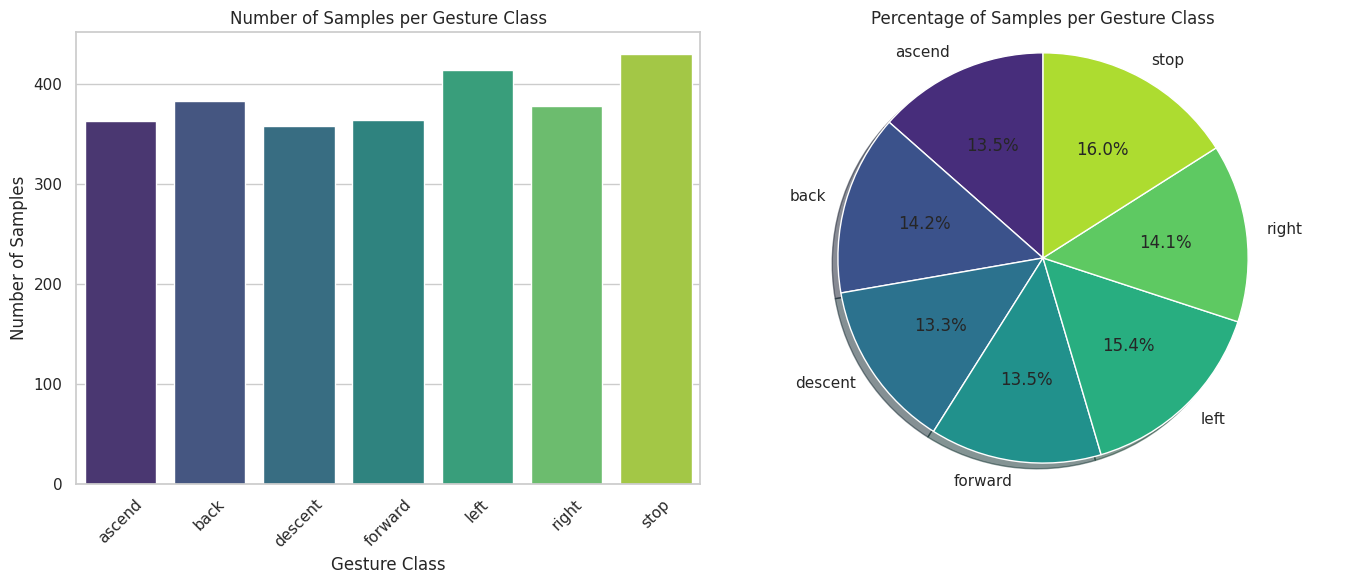

Total number of samples: 2690
Number of unique classes: 7

Samples per class:
  ascend: 363 samples (13.5%)
  back: 383 samples (14.2%)
  descent: 358 samples (13.3%)
  forward: 364 samples (13.5%)
  left: 414 samples (15.4%)
  right: 378 samples (14.1%)
  stop: 430 samples (16.0%)


In [8]:
def visualize_class_distribution(csv_file):
    """Visualize the distribution of gesture classes in the dataset.
    
    Args:
        csv_file (str): Path to the CSV file containing hand landmark data
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Count samples per class
    class_counts = df['Label'].value_counts().sort_index()
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    
    # Bar plot
    ax1 = plt.subplot(1, 2, 1)
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Number of Samples per Gesture Class')
    plt.xlabel('Gesture Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Pie chart
    ax2 = plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            startangle=90, shadow=True, colors=sns.color_palette('viridis', len(class_counts)))
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Percentage of Samples per Gesture Class')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total number of samples: {len(df)}")
    print(f"Number of unique classes: {len(class_counts)}")
    print("\nSamples per class:")
    for gesture, count in class_counts.items():
        print(f"  {gesture}: {count} samples ({count/len(df)*100:.1f}%)")

# Example usage:
visualize_class_distribution("left.csv")

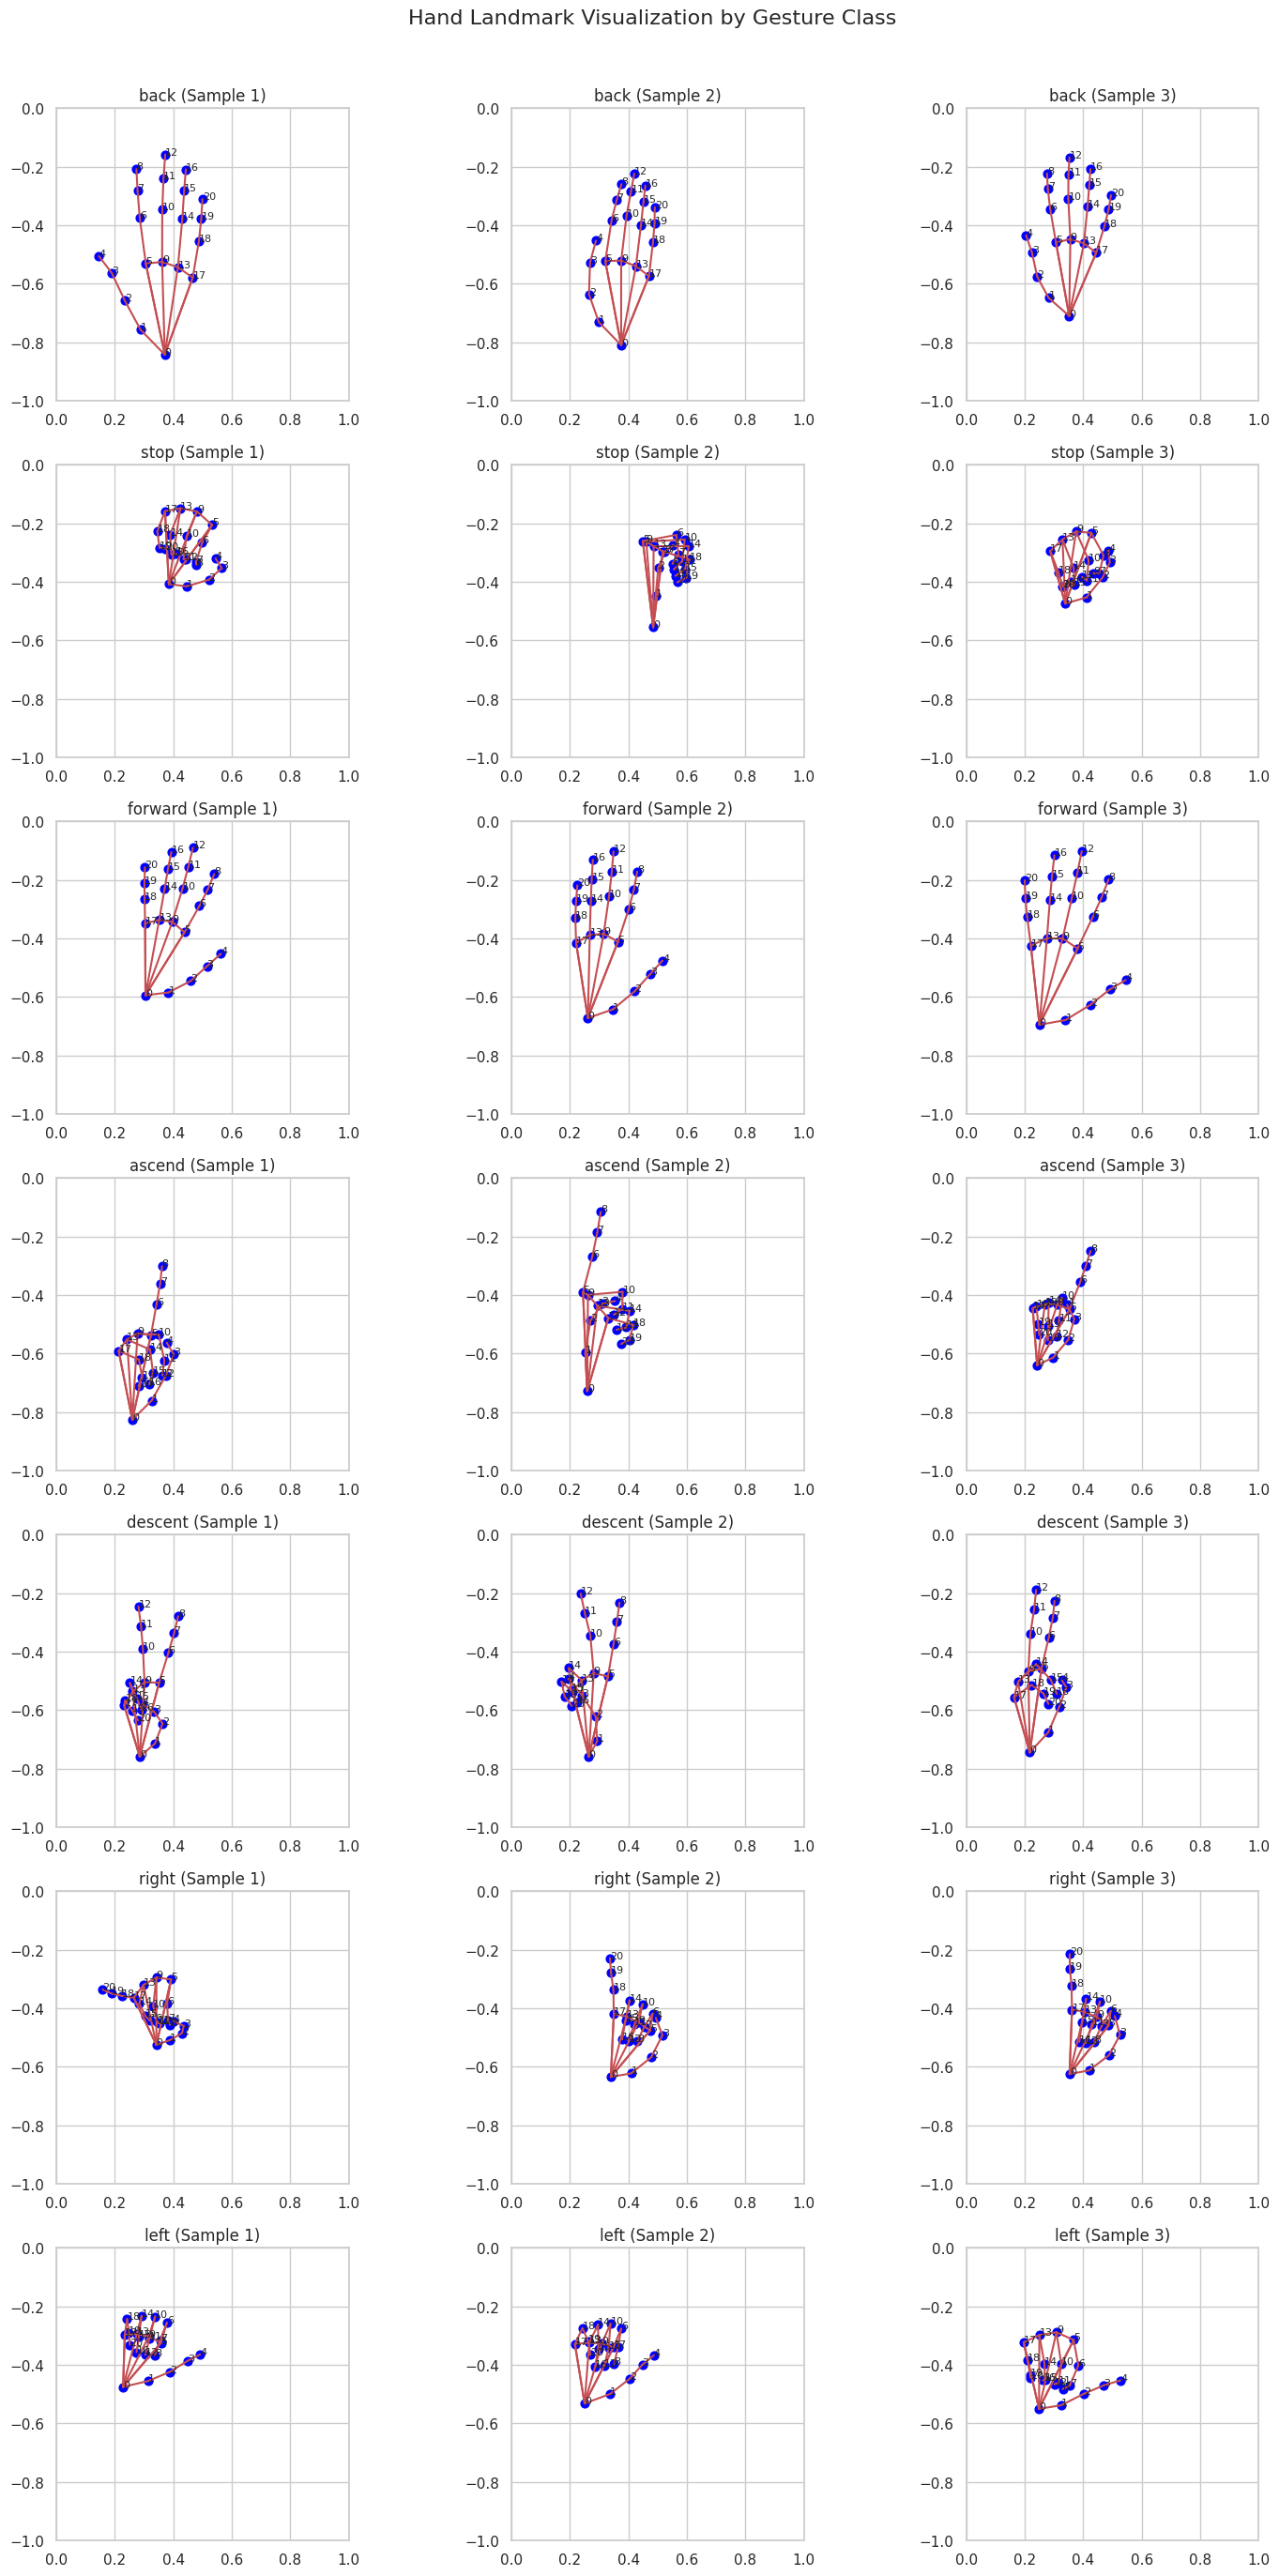

In [9]:
def visualize_hand_landmarks(csv_file, num_samples=3):
    """Visualize hand landmarks for different gesture classes.
    
    Args:
        csv_file (str): Path to the CSV file containing hand landmark data
        num_samples (int): Number of random samples to visualize per class
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Get unique classes
    classes = df['Label'].unique()
    
    # MediaPipe hand connections
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20),  # Pinky finger
        (5, 9), (9, 13), (13, 17), (0, 5), (0, 17)  # Palm connections
    ]
    
    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(15, 4 * len(classes)))
    fig.suptitle('Hand Landmark Visualization by Gesture Class', fontsize=16)
    
    # Function to extract coordinates for a single sample
    def extract_landmarks(row):
        landmarks = []
        for i in range(21):  # 21 landmarks
            x = row[f'Landmark_{i}_X']
            y = row[f'Landmark_{i}_Y']
            landmarks.append((x, y))
        return np.array(landmarks)
    
    # Plot landmarks for each class
    for i, gesture_class in enumerate(classes):
        # Get samples for this class
        class_samples = df[df['Label'] == gesture_class]
        
        # Randomly select samples
        if len(class_samples) > num_samples:
            samples = class_samples.sample(num_samples)
        else:
            samples = class_samples
        
        # Plot each sample
        for j, (_, sample) in enumerate(samples.iterrows()):
            # Create subplot
            ax = fig.add_subplot(len(classes), num_samples, i*num_samples + j + 1)
            
            # Extract landmarks
            landmarks = extract_landmarks(sample)
            
            # Plot landmarks
            for point_idx, (x, y) in enumerate(landmarks):
                # Invert y-axis for correct visualization (0,0 at top-left)
                ax.scatter(x, -y, c='blue', s=40)
                ax.text(x, -y, str(point_idx), fontsize=8)
            
            # Draw connections between landmarks
            for start_idx, end_idx in connections:
                start_point = landmarks[start_idx]
                end_point = landmarks[end_idx]
                ax.plot([start_point[0], end_point[0]], [-start_point[1], -end_point[1]], 'r-')
            
            ax.set_title(f"{gesture_class} (Sample {j+1})")
            ax.set_xlim(0, 1)
            ax.set_ylim(-1, 0)
            ax.set_aspect('equal')
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Example usage:
visualize_hand_landmarks("left.csv", num_samples=3)

In [ ]:
def visualize_feature_space(csv_file, method='pca'):
    """Visualize the hand gesture data in a reduced feature space using PCA or t-SNE.
    
    Args:
        csv_file (str): Path to the CSV file containing hand landmark data
        method (str): Dimensionality reduction method ('pca' or 'tsne')
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Extract features (all landmark coordinates)
    X = df.drop(['Label', 'Handedness'], axis=1).values
    y = df['Label'].values
    
    # Apply dimensionality reduction
    if method.lower() == 'pca':
        reducer = PCA(n_components=3)
        X_reduced = reducer.fit_transform(X)
        method_name = 'PCA'
        explained_var = reducer.explained_variance_ratio_
        print(f"Explained variance ratio: {explained_var[0]:.3f}, {explained_var[1]:.3f}, {explained_var[2]:.3f}")
        print(f"Total explained variance: {sum(explained_var):.3f}")
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
        X_reduced = reducer.fit_transform(X)
        method_name = 't-SNE'
    else:
        raise ValueError("Method must be either 'pca' or 'tsne'")
    
    # Get unique classes and colors
    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(14, 10))
    
    # 3D plot
    ax1 = fig.add_subplot(121, projection='3d')
    for i, cls in enumerate(classes):
        idx = np.where(y == cls)
        ax1.scatter(X_reduced[idx, 0], X_reduced[idx, 1], X_reduced[idx, 2], 
                   c=[colors[i]], label=cls, alpha=0.7, s=50)
    
    ax1.set_title(f'3D Visualization of Hand Gestures Using {method_name}')
    ax1.set_xlabel(f'Component 1')
    ax1.set_ylabel(f'Component 2')
    ax1.set_zlabel(f'Component 3')
    ax1.legend()
    
    # 2D plot (components 1 and 2)
    ax2 = fig.add_subplot(122)
    for i, cls in enumerate(classes):
        idx = np.where(y == cls)
        ax2.scatter(X_reduced[idx, 0], X_reduced[idx, 1], 
                   c=[colors[i]], label=cls, alpha=0.7, s=50)
    
    ax2.set_title(f'2D Visualization of Hand Gestures Using {method_name}')
    ax2.set_xlabel(f'Component 1')
    ax2.set_ylabel(f'Component 2')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print clustering observations
    print(f"\nObservations from {method_name} visualization:")
    print("- The plot shows how different gesture classes are separated in the feature space.")
    print("- Well-separated clusters indicate that the gestures are distinguishable.")
    print("- Overlapping clusters may indicate gestures that are similar and might be confused by the model.")

# Example usage:
# visualize_feature_space("left.csv", method='pca')  # Try also with method='tsne'

## 3. Model Training

### Theory: Neural Networks for Gesture Recognition

Hand gesture recognition can be formulated as a supervised classification problem where the input is a set of hand landmark coordinates, and the output is a probability distribution over possible gesture classes.

**Feature Representation**

For our model, we use the 2D coordinates (X,Y) of the 21 hand landmarks provided by MediaPipe. These 42 values (21 landmarks × 2 coordinates) form our feature vector. We exclude the Z-coordinate (depth) as it can be less reliable in 2D camera setups.

**Data Preprocessing**

Before training, we apply several preprocessing steps:

1. **Min-Max Scaling**: Normalizes feature values to the range [0,1], which helps the neural network converge faster and prevents features with larger ranges from dominating the learning process. The formula is:
   $$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

2. **One-Hot Encoding**: Converts categorical labels into binary vectors. For example, with 7 classes, the label for "Stop" might be encoded as [0,0,0,0,0,0,1].

**Neural Network Architecture**

We use a fully connected feed-forward neural network with the following architecture:

- **Input Layer**: 42 neurons (one for each coordinate)
- **Hidden Layers**: Multiple dense layers with ReLU activation functions
- **Output Layer**: Number of neurons equal to the number of gesture classes, with softmax activation

The ReLU (Rectified Linear Unit) activation function is defined as:
$$f(x) = max(0, x)$$

The softmax activation function converts the raw output scores to probabilities:
$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

**Training and Optimization**

We use the following components for training:

- **Loss Function**: Categorical Cross-Entropy, which measures the difference between the predicted probability distribution and the actual distribution (one-hot encoded labels).
- **Optimizer**: Adam (Adaptive Moment Estimation), which adapts the learning rate for each parameter.
- **Metrics**: Accuracy, which measures the proportion of correctly classified examples.

### Implementation

The code below implements the neural network model for hand gesture recognition, including data loading, preprocessing, model definition, training, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
def train_gesture_model(csv_file, model_name="hand_model.h5"):
    """Train a neural network model for hand gesture recognition.
    
    Args:
        csv_file (str): Path to the CSV file containing hand landmark data
        model_name (str): Name for saving the trained model
        
    Returns:
        tuple: (model, test_accuracy)
    """
    print(f"Training model using data from {csv_file}...")
    
    # Configure TensorFlow to hide warnings and info messages during training
    original_tf_verbosity = tf.get_logger().level
    tf.get_logger().setLevel('ERROR')  # Only show errors, not warnings or info
    
    # Disable eager execution warnings if any
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    # Min-max scale function for normalization
    def min_max_scale_sample(X_train, X_test):
        min_vals = X_train.min(axis=0, keepdims=True)  # Calculate on training data
        max_vals = X_train.max(axis=0, keepdims=True)  # Calculate on training data
        
        # Scale training data
        X_train_scaled = (X_train - min_vals) / (max_vals - min_vals)
        
        # Scale test data using the same min and max values from training
        X_test_scaled = (X_test - min_vals) / (max_vals - min_vals)
        
        return X_train_scaled, X_test_scaled

    # Load the data
    df = pd.read_csv(csv_file)

    # Prepare feature matrix (X) and labels (y)
    # Only use the 42 landmarks, excluding 'Handedness' and 'Label'
    X = df.drop(['Label', 'Handedness'], axis=1).values  # Exclude 'Handedness' and 'Label'
    y = df['Label'].values

    # Display the shape of the data
    print(f"Data shape: {X.shape} features, {len(np.unique(y))} classes")
    print(f"Classes: {np.unique(y)}")

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069)
    print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

    # Normalize the data (min-max scaling)
    X_train_scaled, X_test_scaled = min_max_scale_sample(X_train, X_test)

    # Convert labels to integer and then to categorical (one-hot encoding)
    unique_labels = np.unique(y)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    y_train_cat = to_categorical([label_to_int[label] for label in y_train])
    y_test_cat = to_categorical([label_to_int[label] for label in y_test])

    # Build the model
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(len(unique_labels), activation='softmax')
    ])

    # Display model summary
    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Configure callback to reduce verbosity during training
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 10 == 0:  # Print only every 10 epochs
                print(f"Epoch {epoch+1}/100 - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
    
    # Train the model with reduced verbosity
    history = model.fit(
        X_train_scaled, y_train_cat, 
        epochs=100, 
        batch_size=32, 
        validation_split=0.1,
        verbose=0,  # Set to 0 to hide progress bar
        callbacks=[CustomCallback()]
    )

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    print(f'Test accuracy: {test_accuracy:.4f}')

    # Save the model
    model.save(model_name)
    print(f"Model saved to '{model_name}'.")
    
    # Save the label mapping for later use in prediction
    label_mapping = pd.DataFrame({
        'index': list(label_to_int.values()),
        'label': list(label_to_int.keys())
    })
    label_mapping.to_csv(model_name.replace('.h5', '_labels.csv'), index=False)
    print(f"Label mapping saved to '{model_name.replace('.h5', '_labels.csv')}'.")
    
    # Restore original TensorFlow verbosity level
    tf.get_logger().setLevel(original_tf_verbosity)
    
    return model, test_accuracy, unique_labels

# Example usage:
# model, accuracy, labels = train_gesture_model("left.csv", "hand_model_left.h5")

## 4. Real-time Prediction

### Theory: Real-time Gesture Recognition

Real-time hand gesture recognition involves continuously processing video frames to detect hands, extract landmarks, and classify gestures. This process includes several key components:

**1. Frame Processing Pipeline**

For each video frame, we follow this pipeline:
- Capture a frame from the webcam
- Convert the color format from BGR (OpenCV default) to RGB (MediaPipe input format)
- Process the frame with MediaPipe Hands to detect landmarks
- Extract and normalize the landmark coordinates
- Input the normalized coordinates to the trained model
- Visualize the results on the original frame

**2. Multi-Hand Detection**

Our system can detect and classify gestures from both hands simultaneously. This requires:
- Configuring MediaPipe to detect multiple hands
- Determining whether each detected hand is left or right
- Selecting the appropriate model for each hand

**3. Landmark Normalization**

Before feeding hand landmarks to the model, we normalize them using the same min-max scaling approach as during training. However, since we're processing a single sample at a time, we normalize based on the landmarks of the current frame only:

$$X_{normalized} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

This normalization makes the feature representation invariant to hand size and position in the frame, focusing on the relative positions of landmarks that define the gesture.

**4. Confidence Thresholding**

To reduce false positives, we implement confidence thresholding. The model outputs a probability distribution over all possible gestures. We only display a prediction if its confidence exceeds a threshold (e.g., 95%).

### Implementation

The following code implements real-time hand gesture recognition using the trained models.

In [4]:
def predict_gestures(left_model_path='hand_model_left.h5', right_model_path='hand_model_right.h5',
                    left_labels=None, right_labels=None):
    """Real-time hand gesture recognition using webcam.
    
    Args:
        left_model_path (str): Path to the left hand model
        right_model_path (str): Path to the right hand model
        left_labels (list): List of labels for left hand gestures
        right_labels (list): List of labels for right hand gestures
    """
    import cv2
    import mediapipe as mp
    import numpy as np
    from tensorflow.keras.models import load_model
    import tensorflow as tf
    
    # Suppress TensorFlow warnings
    tf.get_logger().setLevel('ERROR')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
    
    # Suppress OpenCV warnings
    cv2.setUseOptimized(True)
    cv2.useOptimized()
    
    # Function to normalize input features
    def min_max_scale_sample(X):
        min_vals = X.min(axis=1, keepdims=True)
        max_vals = X.max(axis=1, keepdims=True)
        scaled_X = (X - min_vals) / (max_vals - min_vals)
        return scaled_X

    # Define default labels if not provided
    if left_labels is None:
        left_labels = ['Ascend', 'Backward', 'Descent', 'Forward', 'Right', 'Left', 'Stop']
    if right_labels is None:
        right_labels = ['Ascend', 'Backward', 'Descent', 'Forward', 'Left', 'Right', 'Stop']

    # Load the models
    print(f"Loading models: {left_model_path} and {right_model_path}")
    left_hand_model = load_model(left_model_path, compile=False)
    right_hand_model = load_model(right_model_path, compile=False)

    # MediaPipe setup
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        min_detection_confidence=0.9,
        min_tracking_confidence=0.9,
        max_num_hands=2  # Allow detection of two hands
    )

    cap = cv2.VideoCapture(0)
    print("Starting webcam for gesture recognition. Press 'q' to quit.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)  # Flip the frame horizontally for a mirrored view
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = hands.process(image_rgb)

        if results.multi_hand_landmarks and results.multi_handedness:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                # Determine if the hand is left or right
                hand_label = handedness.classification[0].label  # "Left" or "Right"
                hand_coords = np.array([[lm.x, lm.y] for lm in hand_landmarks.landmark])

                # Flatten the landmarks for model input
                flattened_landmarks = hand_coords.flatten()

                # Normalize the landmarks
                normalized_input = min_max_scale_sample(flattened_landmarks.reshape(1, -1))

                # Use the appropriate model and labels for the hand
                if hand_label == "Left":
                    prediction = left_hand_model.predict(normalized_input, verbose=0)
                    labels = left_labels
                else:
                    prediction = right_hand_model.predict(normalized_input, verbose=0)
                    labels = right_labels

                predicted_class = np.argmax(prediction)
                confidence = prediction[0][predicted_class]

                if confidence > 0.95:
                    if predicted_class < len(labels):
                        predicted_label = labels[predicted_class]
                    else:
                        predicted_label = 'Unknown'

                    x_coord = int(hand_landmarks.landmark[0].x * frame.shape[1])
                    y_coord = int(hand_landmarks.landmark[0].y * frame.shape[0])

                    cv2.putText(frame, f"{hand_label} Hand: {predicted_label}", (x_coord, y_coord - 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                    cv2.putText(frame, f"Confidence: {confidence*100:.2f}%", (x_coord, y_coord - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow('Hand Gesture Recognition', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
predict_gestures()

Loading models: hand_model_left.h5 and hand_model_right.h5
Starting webcam for gesture recognition. Press 'q' to quit.


I0000 00:00:1744701345.743741   71722 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744701345.745107   72517 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)
W0000 00:00:1744701345.764034   72511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744701345.783995   72509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Complete Workflow Example

### Building a Full Gesture Recognition System

Creating a complete hand gesture recognition system involves several stages that build upon each other. The workflow below demonstrates how to execute the full pipeline from data collection to real-time prediction.

This modular approach allows for flexibility in adapting the system to different gesture sets or applications. You can customize the gesture vocabulary, adjust model parameters, or integrate the system with other applications that respond to the recognized gestures.

**Key stages:**

1. **Data Collection** - Gathering landmark data for each gesture type
2. **Data Augmentation** - Converting right-hand data to left-hand data
3. **Data Integration** - Combining datasets into comprehensive training sets
4. **Model Training** - Creating specialized models for each hand
5. **Deployment** - Implementing real-time recognition

Uncomment and execute each section of the code below to implement the complete system.

In [ ]:
# Complete Workflow

# 1. Collect hand gesture data
gestures = ['Ascend', 'Backward', 'Descent', 'Forward', 'Right', 'Left', 'Stop']
for gesture in gestures:
    right_file = collect_hand_data(gesture_name=gesture, hand_side="right")

# 2. Convert right-hand gestures to left-hand gestures
for gesture in gestures:
    right_file = f"{gesture}_right.csv"
    left_file = convert_right_to_left(right_file)

# 3. Combine all data for each hand
def combine_csv_files(files, output_file):
    dfs = [pd.read_csv(f) for f in files]
    combined = pd.concat(dfs, ignore_index=True)
    combined.to_csv(output_file, index=False)
    print(f"Combined data saved to {output_file}")
    return output_file

right_files = [f"{gesture}_right.csv" for gesture in gestures]
left_files = [f"{gesture}_left.csv" for gesture in gestures]

right_combined = combine_csv_files(right_files, "right.csv")
left_combined = combine_csv_files(left_files, "left.csv")

# 4. Train models
right_model, right_acc, right_labels = train_gesture_model("right.csv", "hand_model_right.h5")
left_model, left_acc, left_labels = train_gesture_model("left.csv", "hand_model_left.h5")

# 5. Run real-time prediction
predict_gestures(left_labels=left_labels, right_labels=right_labels)

## Conclusion

### Summary and Future Directions

This project demonstrates a complete pipeline for hand gesture recognition using computer vision and deep learning. By leveraging MediaPipe's hand landmark detection capabilities and a custom neural network architecture, we've created a system that can recognize multiple gestures from both left and right hands in real-time.

**Key Achievements:**

1. **Effective Data Collection** - Streamlined process for capturing hand landmark data
2. **Data Augmentation** - Mirroring technique to generate left-hand data from right-hand data
3. **Robust Model Architecture** - Multi-layer neural network achieving high accuracy
4. **Real-time Processing** - System operates smoothly on standard webcam input

**Potential Applications:**

- **Sign Language Translation** - Converting sign language gestures to text or speech
- **Smart Home Control** - Touchless control of lights, appliances, and other devices
- **Augmented Reality Interaction** - Natural hand-based interfaces for AR applications
- **Robotics** - Intuitive control of robotic systems through hand gestures
- **Accessibility** - Providing alternative input methods for individuals with mobility impairments

**Future Improvements:**

- **Temporal Modeling** - Incorporating sequence modeling (LSTM/GRU) to recognize dynamic gestures
- **Transfer Learning** - Leveraging pre-trained models to improve accuracy with less data
- **Multi-Gesture Recognition** - Detecting combinations of gestures from both hands simultaneously
- **Efficiency Optimization** - Reducing model size for deployment on edge devices
- **Continuous Learning** - Implementing on-device learning to adapt to user-specific gestures

This implementation provides a solid foundation for these extensions, demonstrating the fundamental techniques needed for effective hand gesture recognition.